In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, cross_validate
from sklearn.metrics import accuracy_score
from scipy import linalg
import numpy as np
import pandas as pd
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Setup

In [5]:
from utils import *

plt.rc('legend', frameon=False)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_style("white", rc=custom_params)
sns.set_palette("pastel")

In [6]:
for index, row in df_experiments.iterrows():
    print(f"Mouse: {row['mouse_id']}, Trial ID: {row['trial_id']}, Area: {row['area']}")
    
    # Lets read
    mouse = Mouse.from_database(
        trial_id=row['trial_id'],
        mouse_name=row['mouse_id'],
        expt_class=ImagingExperiment
    ) # returns df
    expt = mouse[0] # df
    bd_exp = expt.format_behavior_data() # dict
    # for key in bd_exp.keys(): print(key)
    
    # Get or Make ICRWL and place maps
    ICRWL = get_or_make_ICRWL(expt, bd_exp)
    place_maps, smooth_place_maps = get_or_make_place_maps(expt)
    break

Mouse: ek045, Trial ID: 34941, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded


## data exploration

Questions
- The order of the context is not shuffled?
- There are many trials but should there not be trial number of laps? why do the laps reset?

In [7]:
smooth_place_maps.shape, ICRWL.shape, ICRWL.columns

((702, 147, 100),
 (145, 6),
 Index(['Unnamed: 0', 'lap_index', 'context', 'reward_trial', 'water',
        'lick_or_not'],
       dtype='object'))

In [8]:
trials_table = ICRWL.reset_index()[['lap_index', 'context', 'reward_trial', 'water', 'lick_or_not']]
print(trials_table)

     lap_index context  reward_trial  water  lick_or_not
0            0    ctxD         False  False        False
1            1    ctxA          True   True         True
2            2    ctxB          True   True         True
3            3    ctxC         False  False        False
4            4    ctxA          True   True         True
..         ...     ...           ...    ...          ...
140          8    ctxA          True   True         True
141          9    ctxC         False  False        False
142         10    ctxD         False  False        False
143         11    ctxB          True   True         True
144          0    ctxD         False  False        False

[145 rows x 5 columns]


In [9]:
# Cropping cuz smooth place maps records more trails than behavioral data
dfof = smooth_place_maps[:,:len(trials_table), :]
dfof.shape

(702, 145, 100)

In [10]:
auc = np.trapz(dfof, axis=2)
auc.shape

(702, 145)

## Trial decoding. (time summarized)

### Explanation

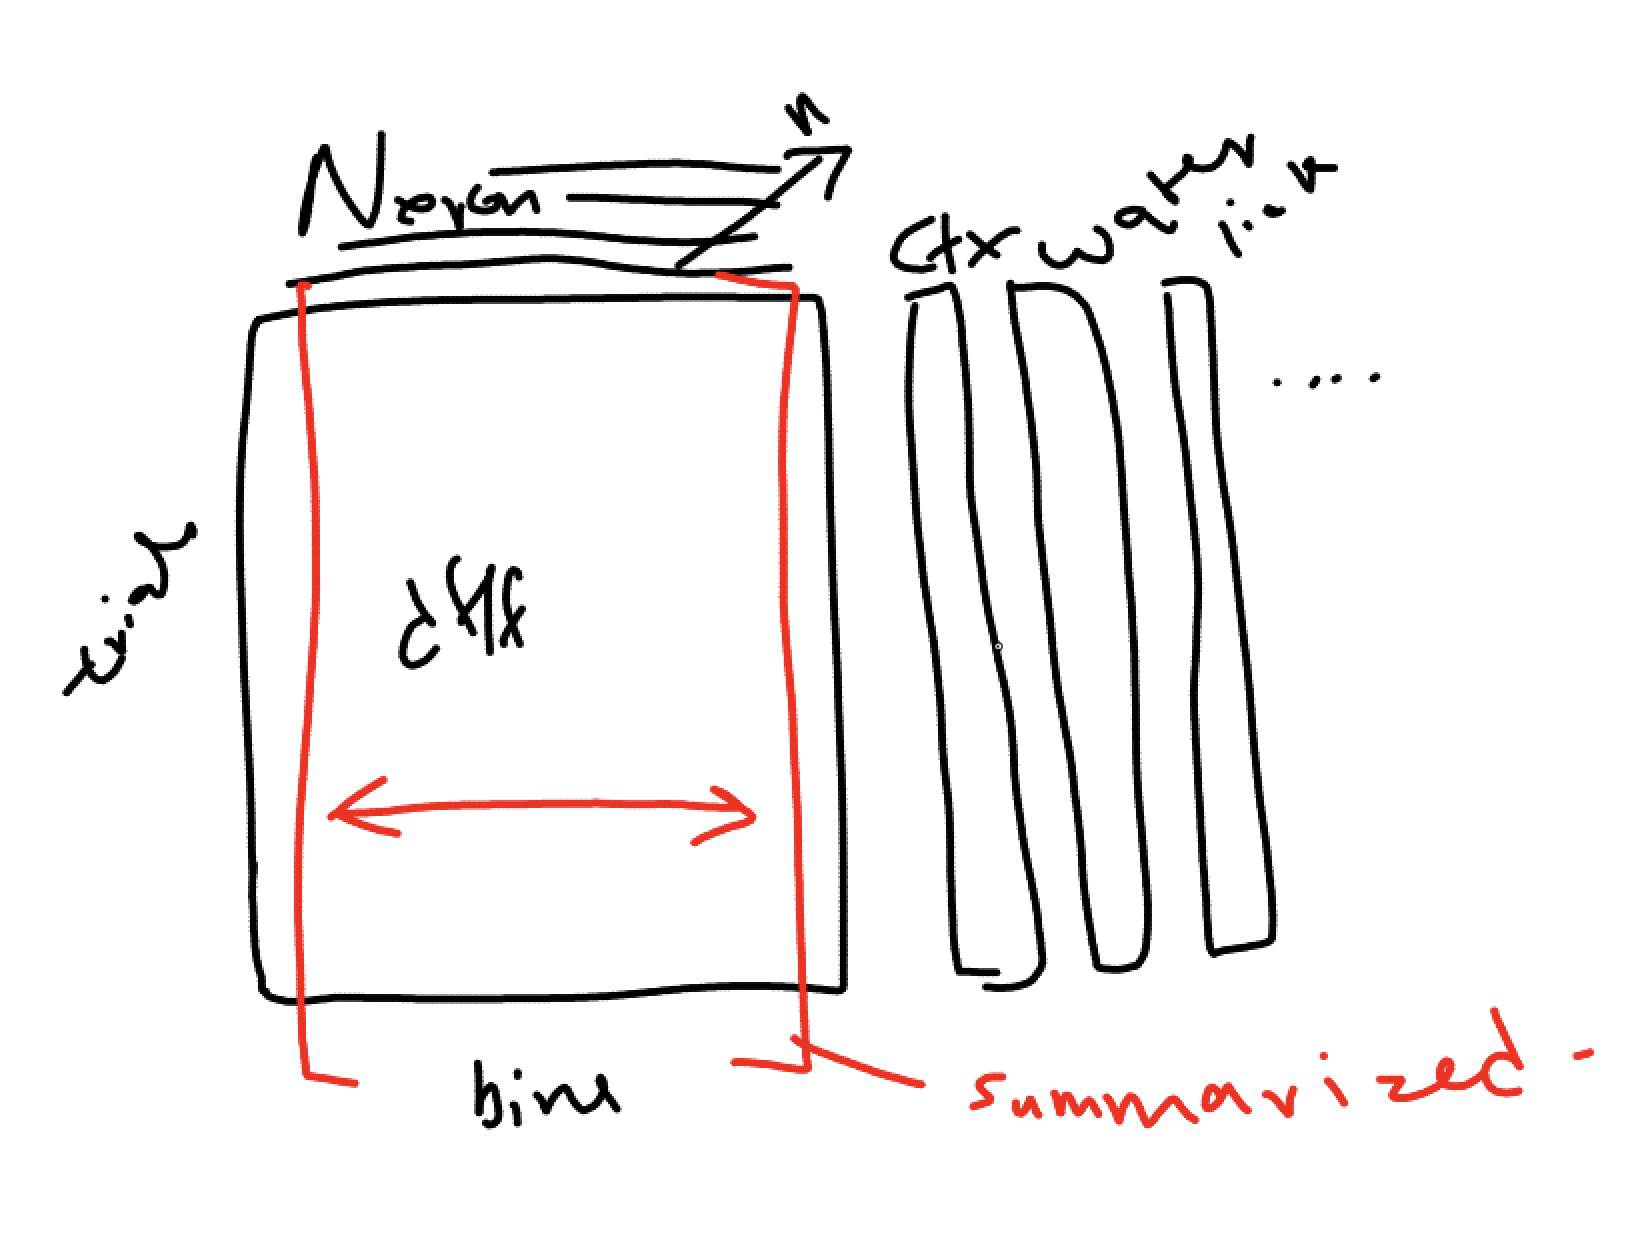


Different targets to decode:

$$CTX_{trial} = \beta_0 + \beta_1 * \int \text{df/f}_{trial}(t) \, dt$$
$$RW_{trial} = \beta_0 + \beta_1 * \int \text{df/f}_{trial}(t) \, dt$$
$$LICK_{trial} = \beta_0 + \beta_1 * \int \text{df/f}_{trial}(t) \, dt$$


### Implementation

In [34]:
targets = {
    'context': trials_table.context.values,
    'water': trials_table.water.values,
    'lick_or_not': trials_table.lick_or_not.values
}

results = []
for neuron_idx in tqdm.tqdm(range(auc.shape[0])):
    neuron_auc = auc[neuron_idx, :].reshape(-1, 1)
    
    for target_name, target_data in targets.items():
        model = LogisticRegression(max_iter=1000)
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        
        scoring = {
            'accuracy': 'accuracy',
            'roc_auc': 'roc_auc_ovr',
            'f1': 'f1_weighted'
        }
        
        cv_results = cross_validate(model, neuron_auc, target_data, 
                                    cv=kfold, scoring=scoring, 
                                    return_train_score=True)
        
        results.append({
            'neuron': neuron_idx,
            'target': target_name,
            'train_acc': cv_results['train_accuracy'].mean(),
            'test_acc': cv_results['test_accuracy'].mean(),
            'train_auc': cv_results['train_roc_auc'].mean(),
            'test_auc': cv_results['test_roc_auc'].mean(),
            'train_f1': cv_results['train_f1'].mean(),
            'test_f1': cv_results['test_f1'].mean(),
        })

df_results = pd.DataFrame(results)
df_results.to_csv('decoder_trial_auc.csv', index=False)

100%|██████████| 702/702 [02:05<00:00,  5.61it/s]


### Visualizing the results

In [ ]:
def plot_pairwise(result, title=""):
    
    # Custom function to add diagonal and chance lines
    def add_reference_lines(x, y, **kwargs):
        ax = plt.gca()
        # Diagonal line
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
        # Chance lines
        chance = 0.5
        ax.axhline(chance, color='k', linestyle='--', alpha=0.3, linewidth=1)
        ax.axvline(chance, color='k', linestyle='--', alpha=0.3, linewidth=1)
        # Scatter
        ax.scatter(x, y, alpha=0.2, s=10, marker='.', color='k')

    # Create pairplot with custom styling
    g = sns.pairplot(result, 
                    diag_kind='hist',
                    plot_kws={'alpha': 0.2, 's': 50, 'marker': '.', 'color': 'k'},
                    diag_kws={'color': 'k', 'alpha': 0.5},
                    corner=False,
                    height=3)  # Size of each subplot (default is 2.5)

    # Add reference lines to each subplot
    g.map_offdiag(add_reference_lines)

    # Set limits and grid for all subplots
    for ax in g.axes.flatten():
        if ax is not None:
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.grid(alpha=0.3)
            # Increase tick label size
            ax.tick_params(labelsize=10)

    # Increase axis label size
    for ax in g.axes[-1,:]:  # Bottom row (x-labels)
        ax.xaxis.label.set_size(12)
    for ax in g.axes[:,0]:   # Left column (y-labels)
        ax.yaxis.label.set_size(12)

    plt.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

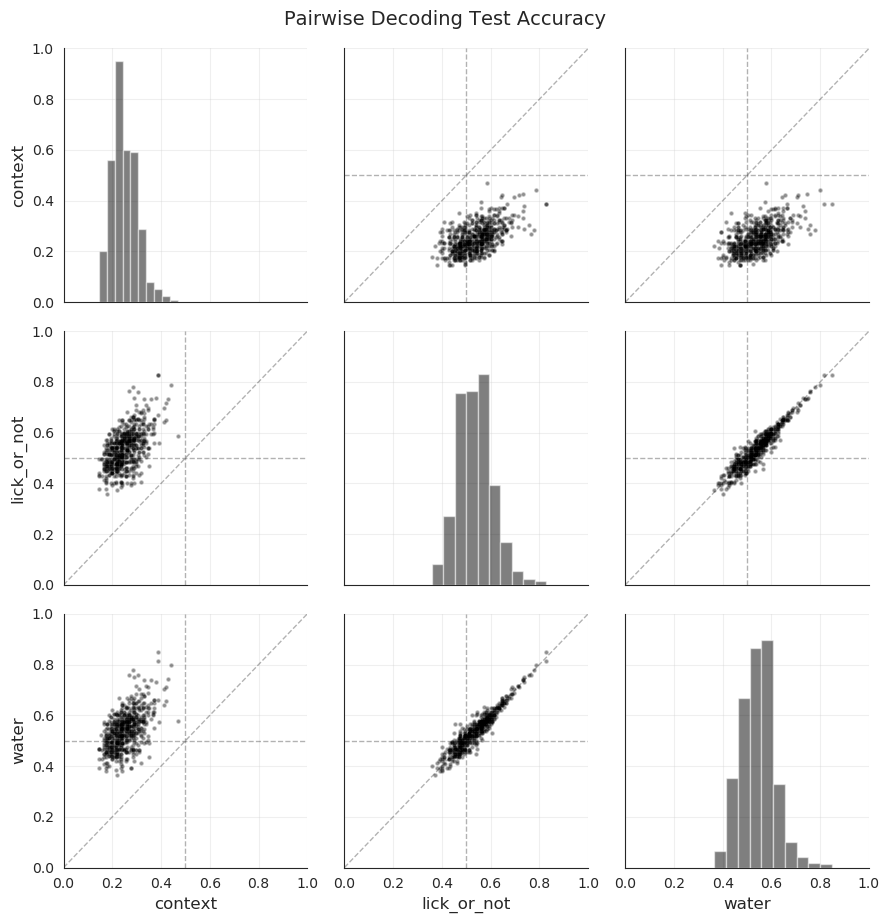

In [ ]:
df_test_acc = df_results.pivot(index='neuron', columns='target', values='test_acc')
plot_pairwise(df_test_acc, title="Pairwise Decoding Test Accuracy")

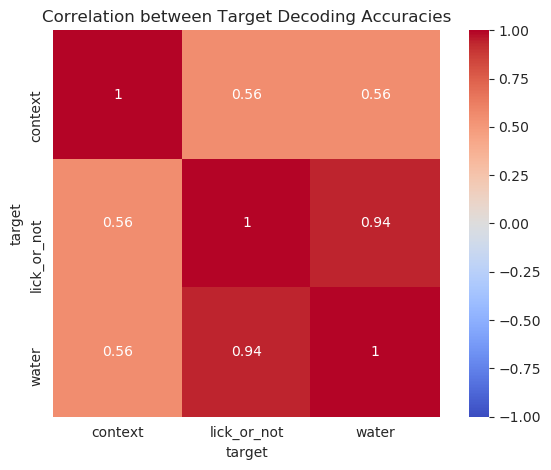

In [ ]:
correlation_matrix = df_test_acc.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True)
plt.title('Correlation between Target Decoding Accuracies')
plt.tight_layout()
plt.show()

## Trial decoding. (Blocked, Time summarized, IBL covariates)

### Explanation

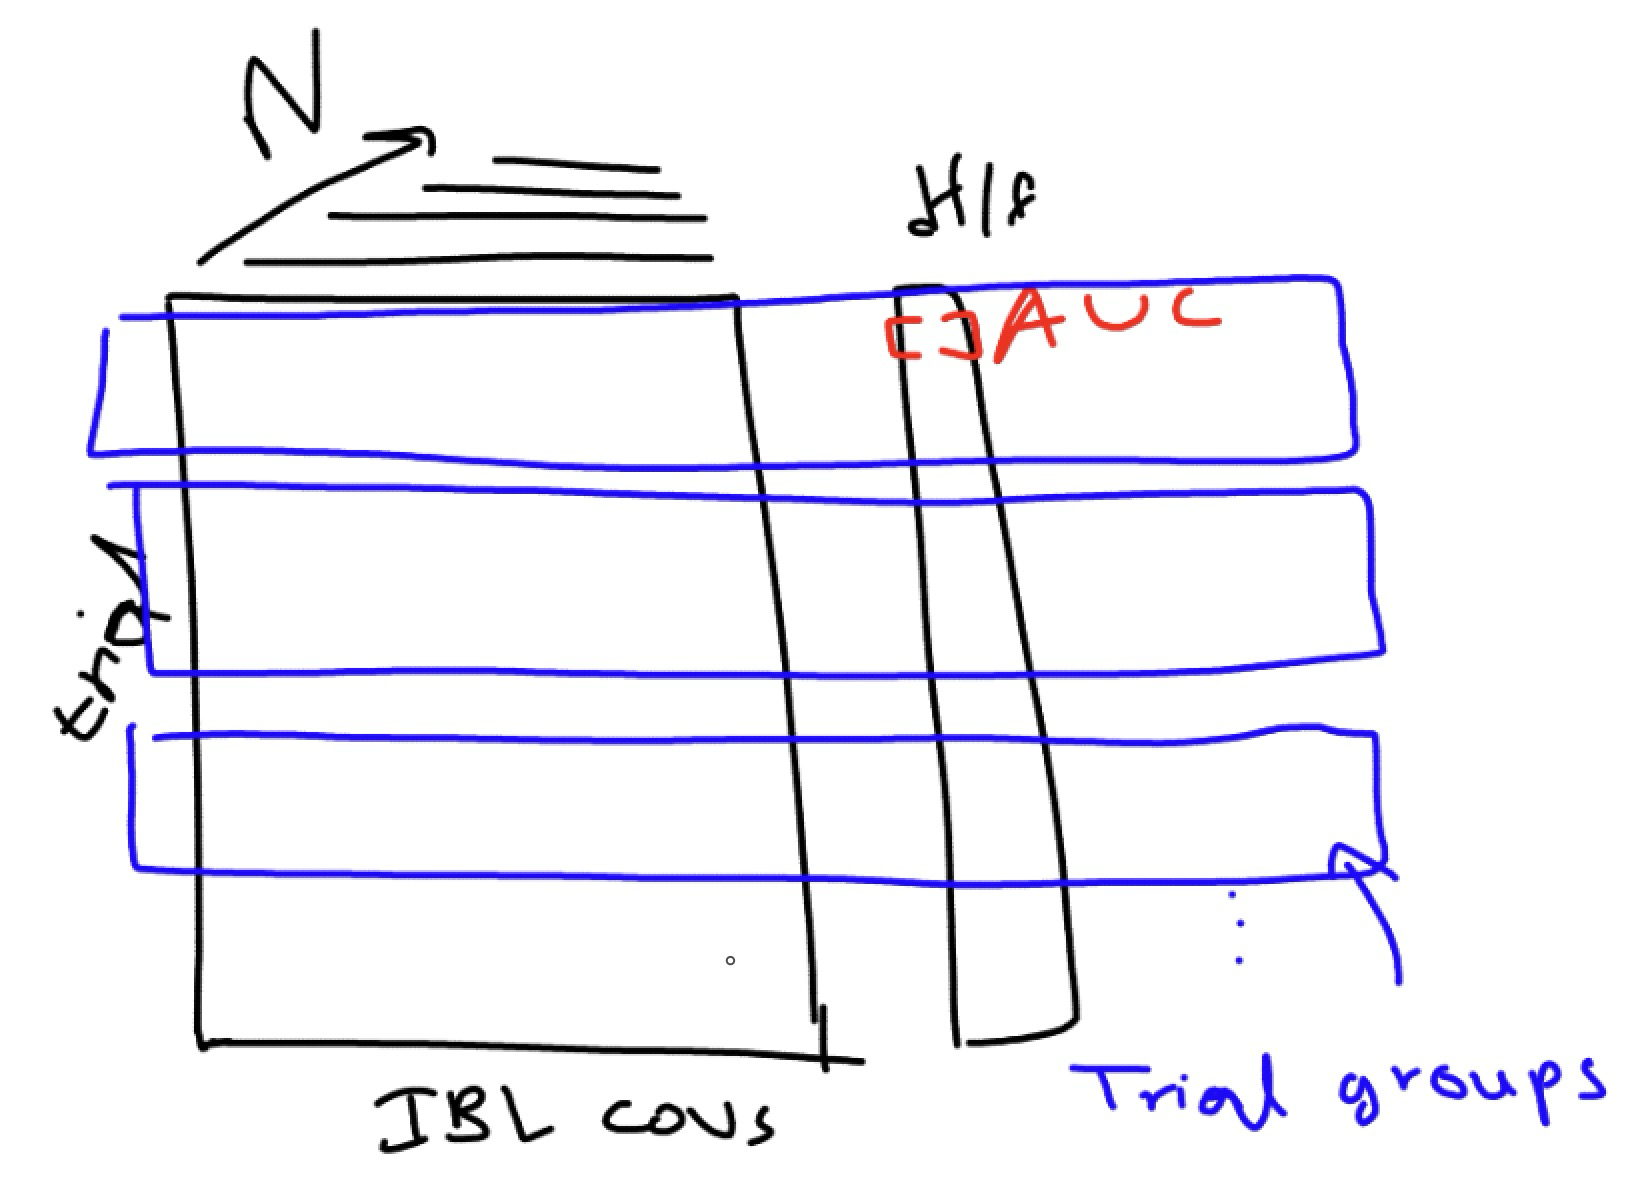

#### Model

Covariates:

<!-- ########### -->
<!-- Timestep Level -->
<!-- Behavior params -->
$spatialbin$: the location from the start point\
$velocity$: velocity at the current position


<!-- ########### -->
<!-- Trial Level -->
<!-- Behavior params -->
<!-- licking value will have bias to keep licking or eager to open mouth -->
$lick$: Licked yes/no\
$licks_{t-1}$: Licked yes/no in the previous trial\

<!-- Task params -->
$water$: watered yes/no\
$water_{t-1}$: Rewarded yes/no in the previous trial\
$context$: ctxA/B/C/D -> converted to 1 or 2\
$context_{t-1}$: Context in the previous trial\

<!-- Stats -->
fit shuffled data accross the bins and see if the coeffs are significant?\

architecture:


$$y_i = \beta_0 + \beta_1 \cdot \text{lick}_i + \beta_2 \cdot \text{lick}_{i-1} + \beta_3 \cdot \text{water}_i + \beta_4 \cdot \text{water}_{i-1} + \beta_5 \cdot \text{context}_i + \beta_6 \cdot \text{context}_{i-1} + \epsilon_i$$

where:
- $y_i = \int_{trial_i} \text{df/f}(t) \, dt$ is the integrated calcium signal for trial $i$
- $i$ indexes trials (not time)
- The subscript $_{i-1}$ refers to the previous trial
- $\epsilon_i$ is the error term
- I binarized the context


### Implementation

In [47]:
print(trials_table.head())

   lap_index context  reward_trial  water  lick_or_not
0          0    ctxD         False  False        False
1          1    ctxA          True   True         True
2          2    ctxB          True   True         True
3          3    ctxC         False  False        False
4          4    ctxA          True   True         True


In [56]:
# Assuming your dataframe is called 'trial_data'
trial_data = trials_table.copy()

# 1. Binarize context: A/B = 0, C/D = 1
trial_data['context_binary'] = trial_data['context'].map({
    'ctxA': 0, 
    'ctxB': 0, 
    'ctxC': 1, 
    'ctxD': 1
}).astype(int)

# 2. Create context_t-1 (previous trial's context)
trial_data['context_t-1'] = trial_data['context_binary'].shift(1)

# 3. Create water_t-1 (previous trial's water)
trial_data['water_t-1'] = trial_data['water'].shift(1)

# 4. Create lick_t-1 (previous trial's lick)
trial_data['lick_t-1'] = trial_data['lick_or_not'].shift(1)

# Convert boolean columns to int (0/1)
trial_data['water'] = trial_data['water'].astype(int)
trial_data['lick_or_not'] = trial_data['lick_or_not'].astype(int)

# Handle NaN BEFORE converting to int
trial_data['water_t-1'] = trial_data['water_t-1'].fillna(0).astype(int)
trial_data['lick_t-1'] = trial_data['lick_t-1'].fillna(0).astype(int)
trial_data['context_t-1'] = trial_data['context_t-1'].fillna(0).astype(int)

# Create your design matrix X
X = trial_data[['lick_or_not', 'lick_t-1', 'water', 'water_t-1', 
                       'context_binary', 'context_t-1']].values

print(f"X shape: {X.shape}")  # Should be (145, 6)

X shape: (145, 6)


In [57]:
print(trial_data[['lick_or_not', 'lick_t-1', 'water', 'water_t-1', 
                         'context_binary', 'context_t-1']].head(10))

   lick_or_not  lick_t-1  water  water_t-1  context_binary  context_t-1
0            0         0      0          0               1            0
1            1         0      1          0               0            1
2            1         1      1          1               0            0
3            0         1      0          1               1            0
4            1         0      1          0               0            1
5            0         1      0          1               1            0
6            1         0      1          0               0            1
7            0         1      0          1               1            0
8            1         0      1          0               0            1
9            0         1      0          1               1            0


In [58]:
y = auc
y.shape

(702, 145)

In [59]:
window_size = 10
n_neurons = 702
n_trials = 145
n_windows = n_trials - window_size + 1  # 136 windows

# Add intercept to X
X_with_intercept = np.column_stack([np.ones(n_trials), X])
# X_with_intercept.shape = (145, 7)

# Preallocate results
betas_over_time = np.zeros((n_windows, n_neurons, X_with_intercept.shape[1]))
r2_over_time = np.zeros((n_windows, n_neurons))

# Sliding window
for w in range(n_windows):
    X_window = X_with_intercept[w:w+window_size]
    y_window = y[:, w:w+window_size]  # (702, 10)
    
    # Solve for all neurons at once
    betas = linalg.lstsq(X_window, y_window.T)[0].T
    betas_over_time[w] = betas
    
    # Calculate R² for each neuron
    y_pred = (X_window @ betas.T).T  # (702, 10)
    ss_res = np.sum((y_window - y_pred)**2, axis=1)
    ss_tot = np.sum((y_window - y_window.mean(axis=1, keepdims=True))**2, axis=1)
    r2_over_time[w] = 1 - (ss_res / ss_tot)

print(f"betas_over_time shape: {betas_over_time.shape}")  # (136, 702, 7)
print(f"r2_over_time shape: {r2_over_time.shape}")        # (136, 702)

betas_over_time shape: (136, 702, 7)
r2_over_time shape: (136, 702)


### Visualizing the results

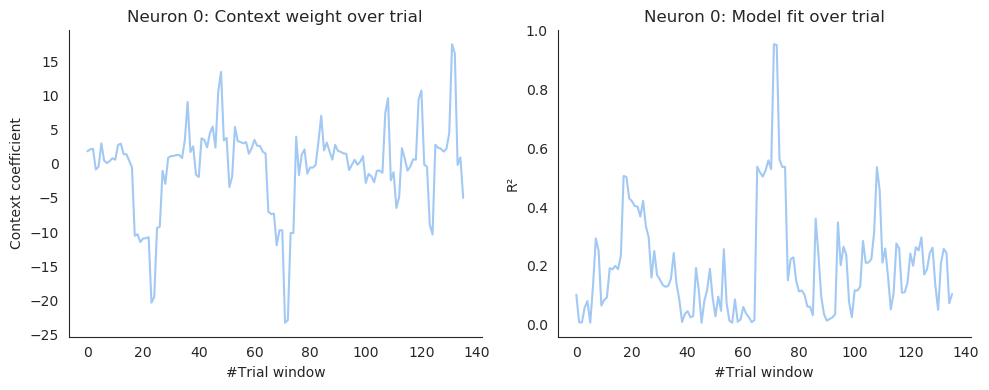

In [61]:
# Example: Plot context coefficient for neuron 0
neuron_idx = 0
context_coef_idx = 5  # context_binary coefficient

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(betas_over_time[:, neuron_idx, context_coef_idx])
plt.xlabel('#Trial window')
plt.ylabel('Context coefficient')
plt.title(f'Neuron {neuron_idx}: Context weight over trial')

plt.subplot(1, 2, 2)
plt.plot(r2_over_time[:, neuron_idx])
plt.xlabel('#Trial window')
plt.ylabel('R²')
plt.title(f'Neuron {neuron_idx}: Model fit over trial')
plt.tight_layout()

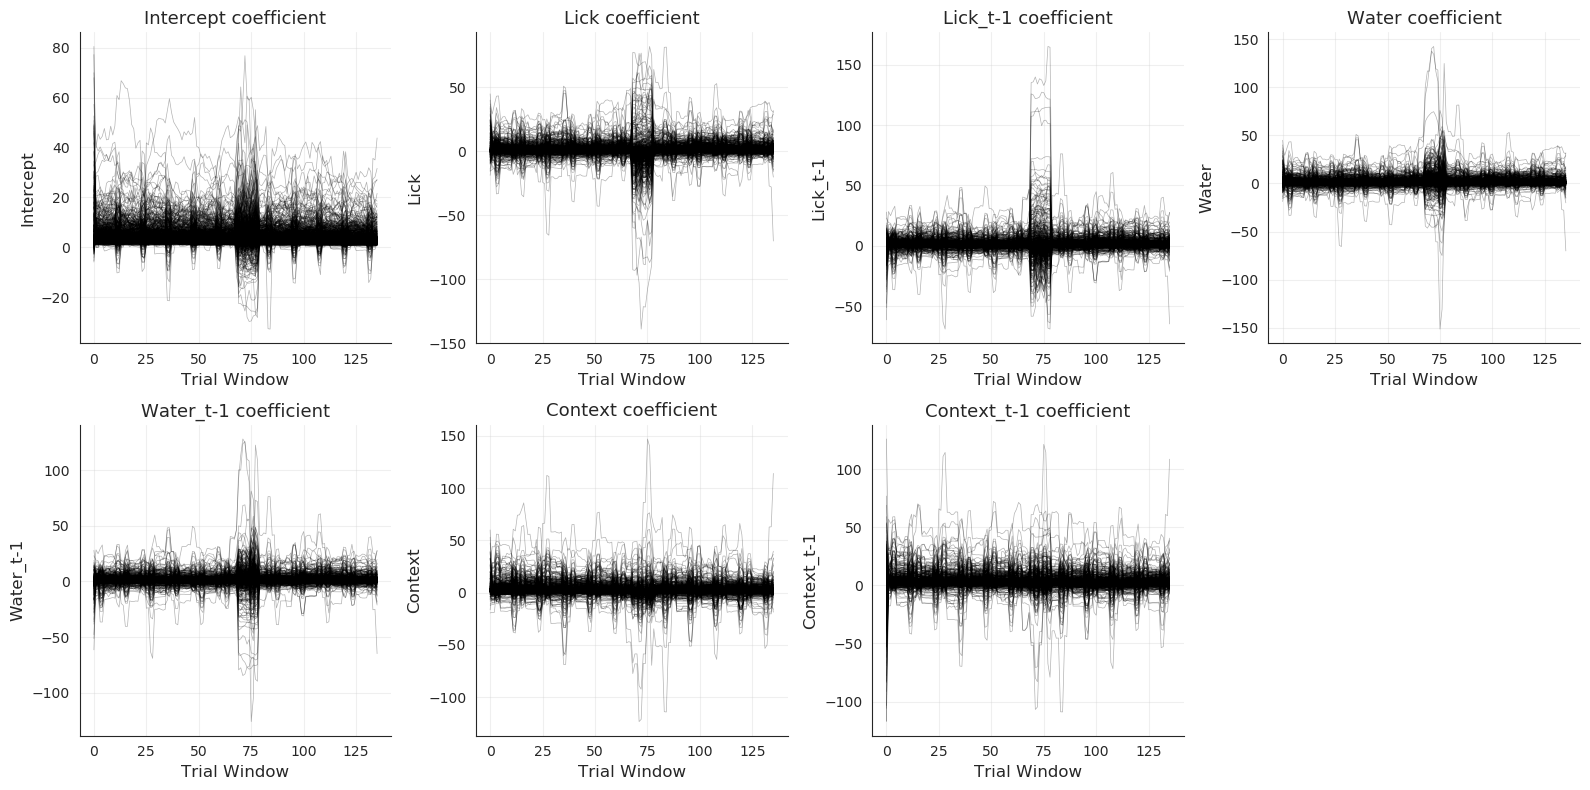

In [63]:
# Coefficient names (matching the order in X_with_intercept)
coef_names = ['Intercept', 'Lick', 'Lick_t-1', 'Water', 'Water_t-1', 'Context', 'Context_t-1']

# Create subplots for all coefficients
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Plot each coefficient
for coef_idx, coef_name in enumerate(coef_names):
    ax = axes[coef_idx]
    
    # Plot all neurons (each neuron is a line)
    for neuron_idx in range(n_neurons):
        ax.plot(betas_over_time[:, neuron_idx, coef_idx], "k-", alpha=0.3, linewidth=0.5)
    
    ax.set_xlabel('Trial Window', fontsize=12)
    ax.set_ylabel(coef_name, fontsize=12)
    ax.set_title(f'{coef_name} coefficient', fontsize=13)
    ax.grid(True, alpha=0.3)

# Remove the empty 8th subplot
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

In [65]:
df_rank = df_results.pivot(index='neuron', columns='target', values='test_acc')
df_rank

target,context,lick_or_not,water
neuron,,,
0,0.296552,0.600000,0.593103
1,0.172414,0.531034,0.510345
2,0.296552,0.579310,0.572414
3,0.227586,0.558621,0.531034
4,0.289655,0.648276,0.641379
...,...,...,...
697,0.172414,0.448276,0.482759
698,0.255172,0.620690,0.627586
699,0.324138,0.613793,0.600000


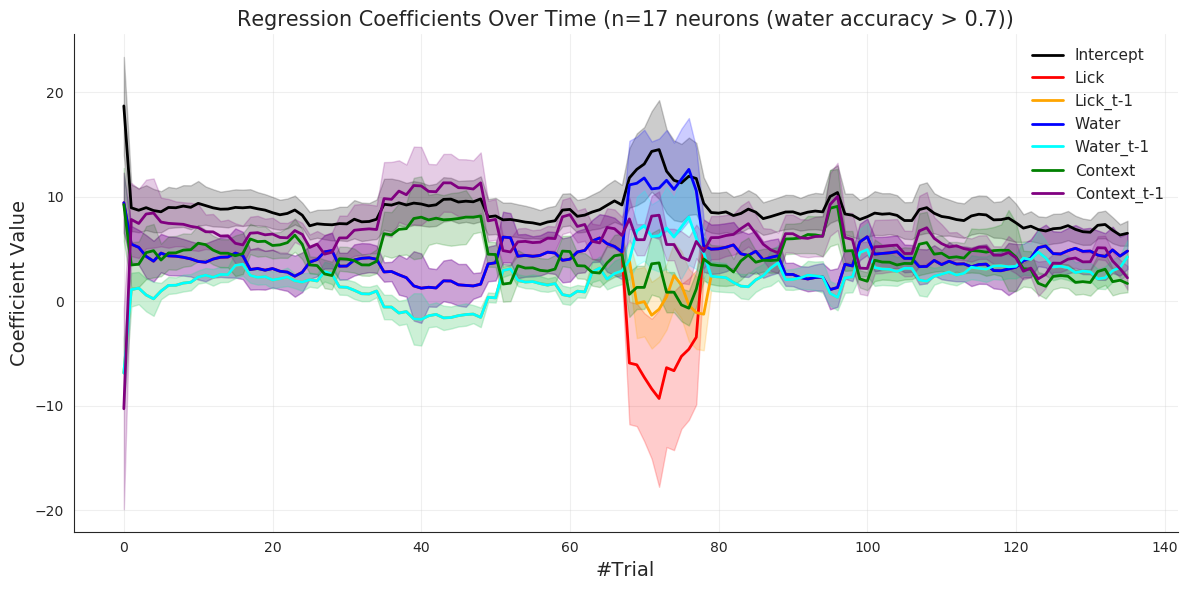

In [ ]:
mask = df_rank.water.values > 0.7
betas_selected = betas_over_time[:, mask, :]


# Coefficient names
coef_names = ['Intercept', 'Lick', 'Lick_t-1', 'Water', 'Water_t-1', 'Context', 'Context_t-1']

# Colors for each coefficient
colors = ['black', 'red', 'orange', 'blue', 'cyan', 'green', 'purple']

plt.figure(figsize=(12, 6))

# Plot each coefficient
for coef_idx, (coef_name, color) in enumerate(zip(coef_names, colors)):
    # Calculate mean and SEM across the 17 neurons
    mean_coef = betas_selected[:, :, coef_idx].mean(axis=1)  # (136,)
    sem_coef = betas_selected[:, :, coef_idx].std(axis=1) / np.sqrt(17)  # SEM
    
    # Plot mean line
    plt.plot(mean_coef, color=color, linewidth=2, label=coef_name)
    
    # Add error bars (shaded region)
    plt.fill_between(range(n_windows), 
                     mean_coef - sem_coef, 
                     mean_coef + sem_coef, 
                     alpha=0.2, color=color)

plt.xlabel('#Trial', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=14)
plt.title('Regression Coefficients Over Time (n=17 neurons (water accuracy > 0.7))', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

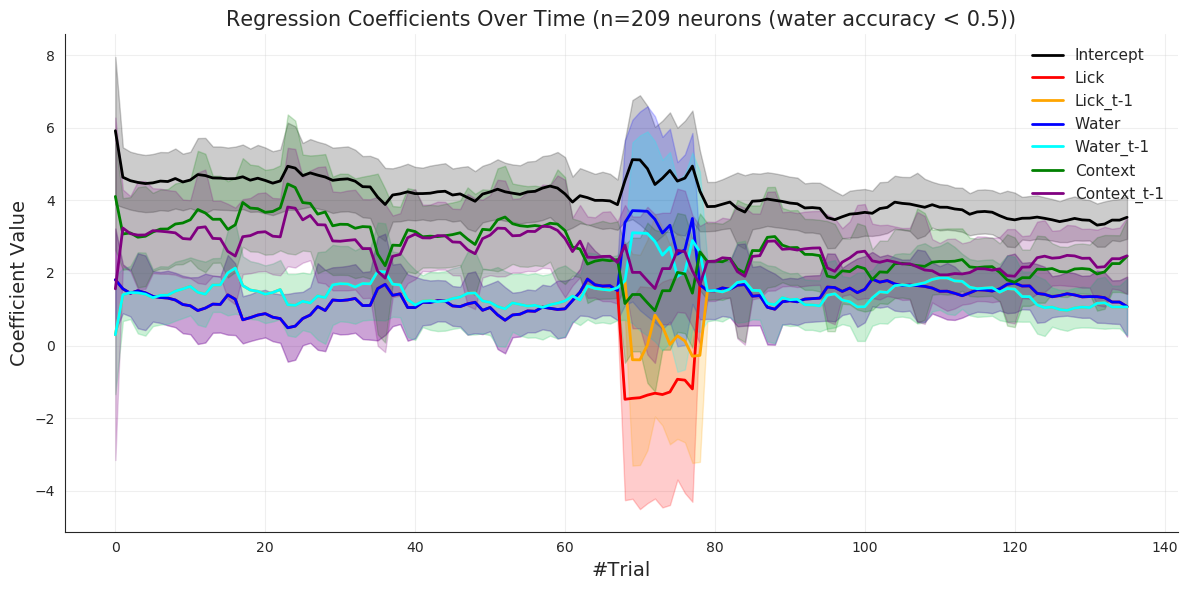

In [77]:
mask = df_rank.water.values < 0.5
betas_selected = betas_over_time[:, mask, :]


# Coefficient names
coef_names = ['Intercept', 'Lick', 'Lick_t-1', 'Water', 'Water_t-1', 'Context', 'Context_t-1']

# Colors for each coefficient
colors = ['black', 'red', 'orange', 'blue', 'cyan', 'green', 'purple']

plt.figure(figsize=(12, 6))

# Plot each coefficient
for coef_idx, (coef_name, color) in enumerate(zip(coef_names, colors)):
    # Calculate mean and SEM across the 17 neurons
    mean_coef = betas_selected[:, :, coef_idx].mean(axis=1)  # (136,)
    sem_coef = betas_selected[:, :, coef_idx].std(axis=1) / np.sqrt(17)  # SEM
    
    # Plot mean line
    plt.plot(mean_coef, color=color, linewidth=2, label=coef_name)
    
    # Add error bars (shaded region)
    plt.fill_between(range(n_windows), 
                     mean_coef - sem_coef, 
                     mean_coef + sem_coef, 
                     alpha=0.2, color=color)

plt.xlabel('#Trial', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=14)
plt.title('Regression Coefficients Over Time (n=209 neurons (water accuracy < 0.5))', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
betas_selected.shape

(136, 209, 7)

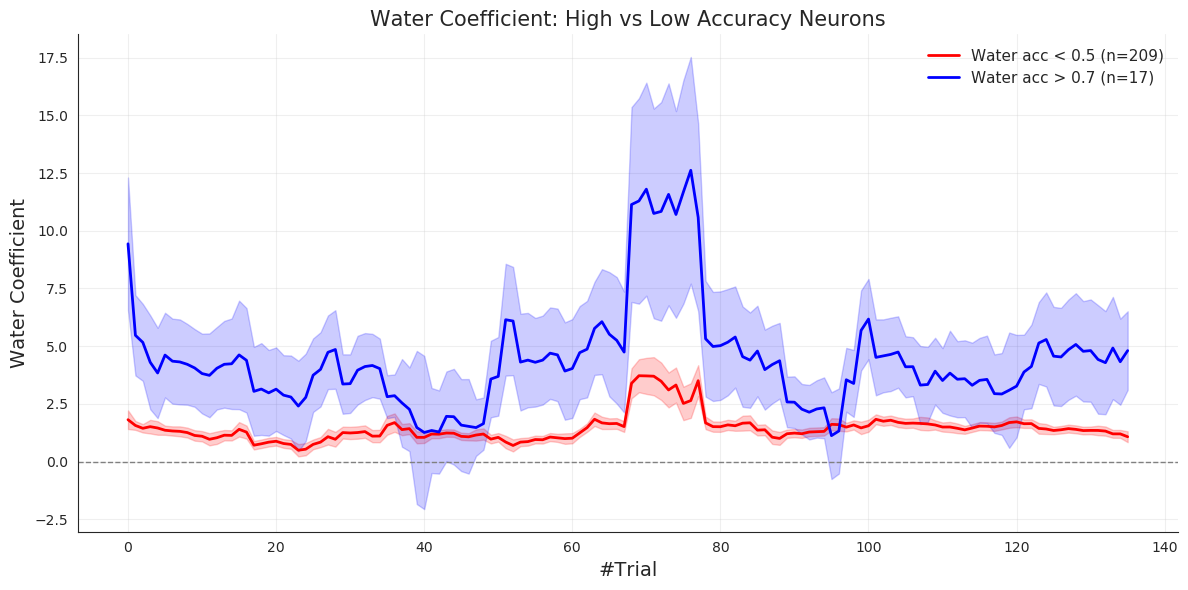

In [78]:
# Select neurons for two groups
mask_low = df_rank.water.values < 0.5
mask_high = df_rank.water.values > 0.7

betas_low = betas_over_time[:, mask_low, :]
betas_high = betas_over_time[:, mask_high, :]

# Water coefficient is at index 3
water_idx = 3

plt.figure(figsize=(12, 6))

# Low accuracy group (acc < 0.5)
mean_low = betas_low[:, :, water_idx].mean(axis=1)
sem_low = betas_low[:, :, water_idx].std(axis=1) / np.sqrt(betas_low.shape[1])

plt.plot(mean_low, color='red', linewidth=2, label=f'Water acc < 0.5 (n={betas_low.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_low - sem_low, 
                 mean_low + sem_low, 
                 alpha=0.2, color='red')

# High accuracy group (acc > 0.7)
mean_high = betas_high[:, :, water_idx].mean(axis=1)
sem_high = betas_high[:, :, water_idx].std(axis=1) / np.sqrt(betas_high.shape[1])

plt.plot(mean_high, color='blue', linewidth=2, label=f'Water acc > 0.7 (n={betas_high.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_high - sem_high, 
                 mean_high + sem_high, 
                 alpha=0.2, color='blue')

plt.xlabel('#Trial', fontsize=14)
plt.ylabel('Water Coefficient', fontsize=14)
plt.title('Water Coefficient: High vs Low Accuracy Neurons', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

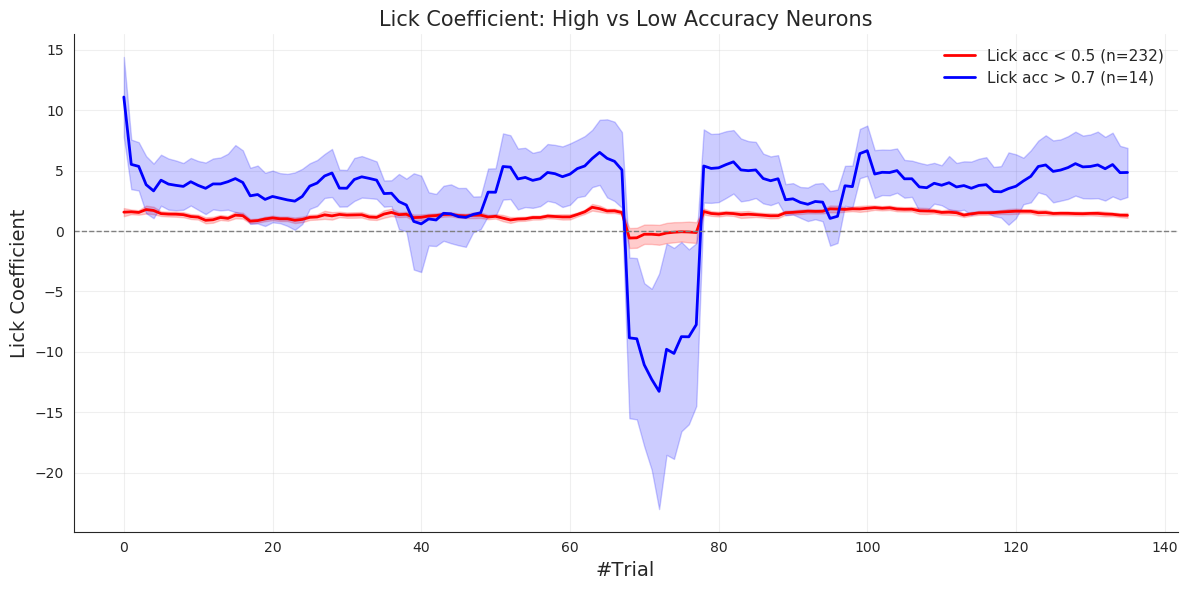

In [82]:
# Select neurons for two groups
mask_low = df_rank.lick_or_not.values < 0.5
mask_high = df_rank.lick_or_not.values > 0.7

betas_low = betas_over_time[:, mask_low, :]
betas_high = betas_over_time[:, mask_high, :]

# Lick coefficient is at index 1
lick_idx = 1

plt.figure(figsize=(12, 6))

# Low accuracy group (acc < 0.5)
mean_low = betas_low[:, :, lick_idx].mean(axis=1)
sem_low = betas_low[:, :, lick_idx].std(axis=1) / np.sqrt(betas_low.shape[1])

plt.plot(mean_low, color='red', linewidth=2, label=f'Lick acc < 0.5 (n={betas_low.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_low - sem_low, 
                 mean_low + sem_low, 
                 alpha=0.2, color='red')

# High accuracy group (acc > 0.7)
mean_high = betas_high[:, :, lick_idx].mean(axis=1)
sem_high = betas_high[:, :, lick_idx].std(axis=1) / np.sqrt(betas_high.shape[1])

plt.plot(mean_high, color='blue', linewidth=2, label=f'Lick acc > 0.7 (n={betas_high.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_high - sem_high, 
                 mean_high + sem_high, 
                 alpha=0.2, color='blue')

plt.xlabel('#Trial', fontsize=14)
plt.ylabel('Lick Coefficient', fontsize=14)
plt.title('Lick Coefficient: High vs Low Accuracy Neurons', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

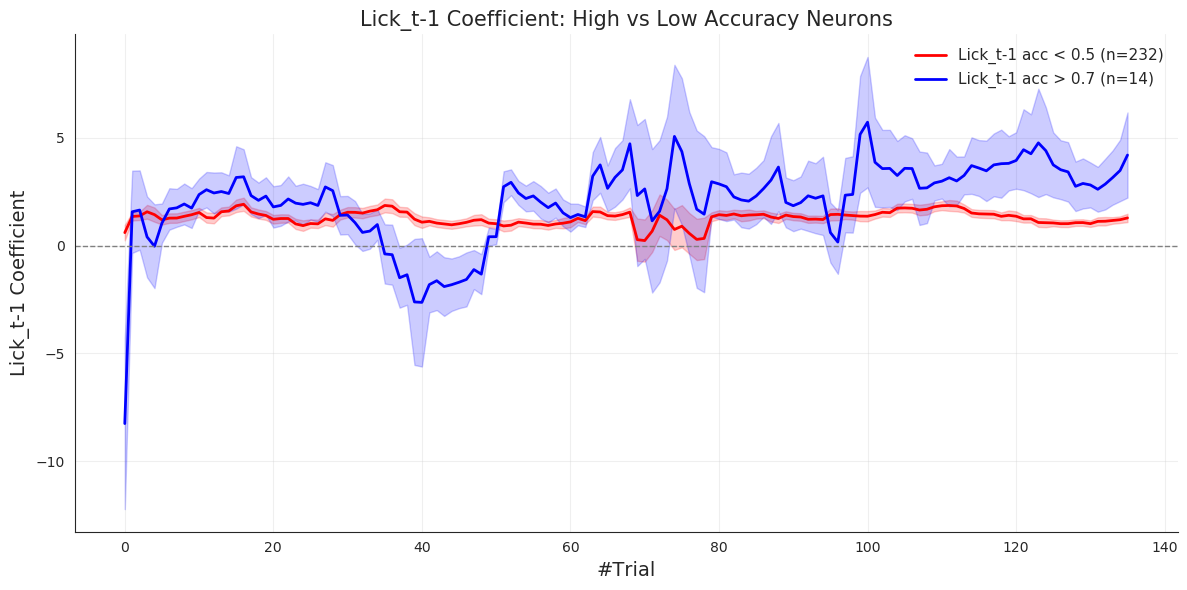

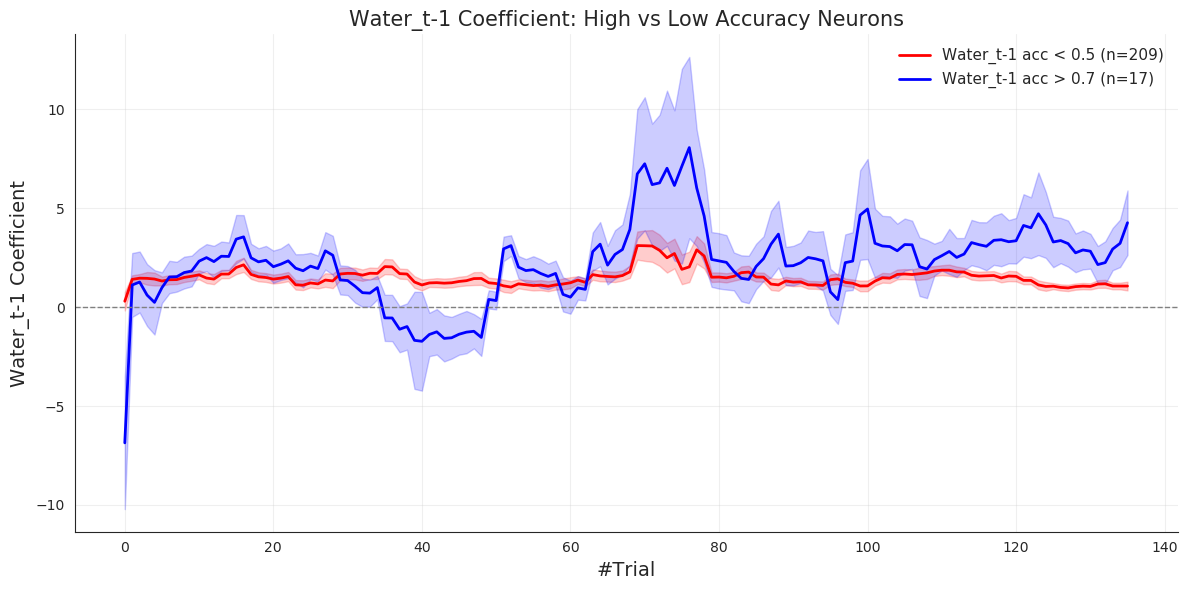

In [83]:
# Lick_t-1 coefficient comparison
mask_low = df_rank.lick_or_not.values < 0.5
mask_high = df_rank.lick_or_not.values > 0.7

betas_low = betas_over_time[:, mask_low, :]
betas_high = betas_over_time[:, mask_high, :]

# Lick_t-1 coefficient is at index 2
lick_t1_idx = 2

plt.figure(figsize=(12, 6))

# Low accuracy group (acc < 0.5)
mean_low = betas_low[:, :, lick_t1_idx].mean(axis=1)
sem_low = betas_low[:, :, lick_t1_idx].std(axis=1) / np.sqrt(betas_low.shape[1])

plt.plot(mean_low, color='red', linewidth=2, label=f'Lick_t-1 acc < 0.5 (n={betas_low.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_low - sem_low, 
                 mean_low + sem_low, 
                 alpha=0.2, color='red')

# High accuracy group (acc > 0.7)
mean_high = betas_high[:, :, lick_t1_idx].mean(axis=1)
sem_high = betas_high[:, :, lick_t1_idx].std(axis=1) / np.sqrt(betas_high.shape[1])

plt.plot(mean_high, color='blue', linewidth=2, label=f'Lick_t-1 acc > 0.7 (n={betas_high.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_high - sem_high, 
                 mean_high + sem_high, 
                 alpha=0.2, color='blue')

plt.xlabel('#Trial', fontsize=14)
plt.ylabel('Lick_t-1 Coefficient', fontsize=14)
plt.title('Lick_t-1 Coefficient: High vs Low Accuracy Neurons', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# Water_t-1 coefficient comparison
mask_low = df_rank.water.values < 0.5
mask_high = df_rank.water.values > 0.7

betas_low = betas_over_time[:, mask_low, :]
betas_high = betas_over_time[:, mask_high, :]

# Water_t-1 coefficient is at index 4
water_t1_idx = 4

plt.figure(figsize=(12, 6))

# Low accuracy group (acc < 0.5)
mean_low = betas_low[:, :, water_t1_idx].mean(axis=1)
sem_low = betas_low[:, :, water_t1_idx].std(axis=1) / np.sqrt(betas_low.shape[1])

plt.plot(mean_low, color='red', linewidth=2, label=f'Water_t-1 acc < 0.5 (n={betas_low.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_low - sem_low, 
                 mean_low + sem_low, 
                 alpha=0.2, color='red')

# High accuracy group (acc > 0.7)
mean_high = betas_high[:, :, water_t1_idx].mean(axis=1)
sem_high = betas_high[:, :, water_t1_idx].std(axis=1) / np.sqrt(betas_high.shape[1])

plt.plot(mean_high, color='blue', linewidth=2, label=f'Water_t-1 acc > 0.7 (n={betas_high.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_high - sem_high, 
                 mean_high + sem_high, 
                 alpha=0.2, color='blue')

plt.xlabel('#Trial', fontsize=14)
plt.ylabel('Water_t-1 Coefficient', fontsize=14)
plt.title('Water_t-1 Coefficient: High vs Low Accuracy Neurons', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

In [92]:
df_rank

target,context,lick_or_not,water
neuron,,,
0,0.296552,0.600000,0.593103
1,0.172414,0.531034,0.510345
2,0.296552,0.579310,0.572414
3,0.227586,0.558621,0.531034
4,0.289655,0.648276,0.641379
...,...,...,...
697,0.172414,0.448276,0.482759
698,0.255172,0.620690,0.627586
699,0.324138,0.613793,0.600000


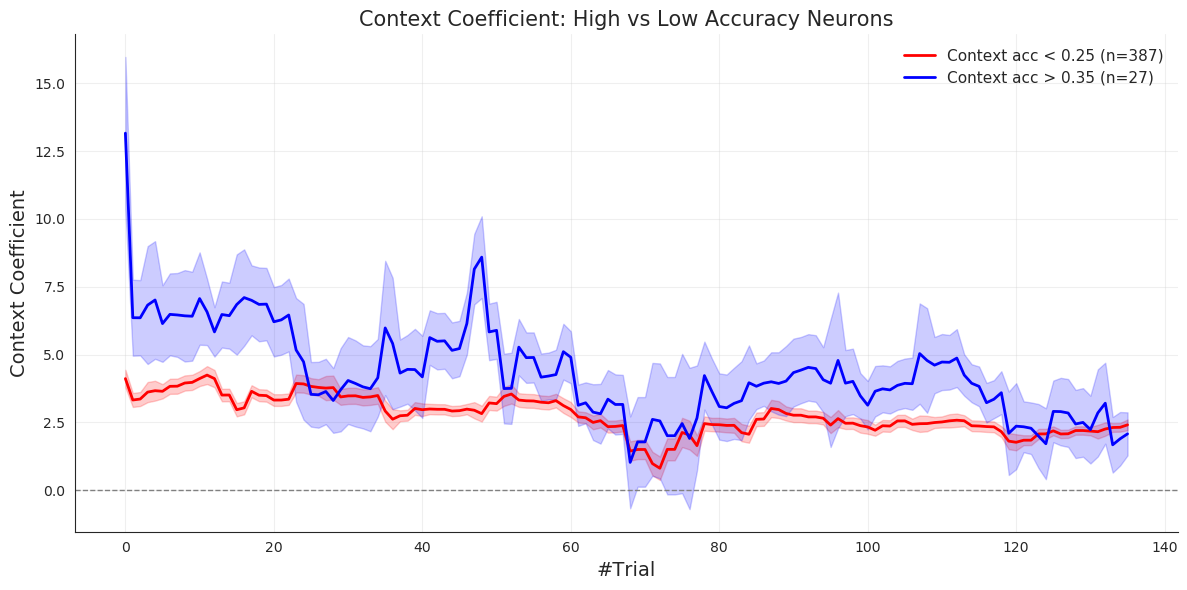

In [103]:
# Context coefficient comparison
mask_low = df_rank.context.values < 0.25
mask_high = df_rank.context.values > 0.35

betas_low = betas_over_time[:, mask_low, :]
betas_high = betas_over_time[:, mask_high, :]

# Context coefficient is at index 5
context_idx = 5

plt.figure(figsize=(12, 6))

# Low accuracy group (acc < 0.5)
mean_low = betas_low[:, :, context_idx].mean(axis=1)
sem_low = betas_low[:, :, context_idx].std(axis=1) / np.sqrt(betas_low.shape[1])

plt.plot(mean_low, color='red', linewidth=2, label=f'Context acc < 0.25 (n={betas_low.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_low - sem_low, 
                 mean_low + sem_low, 
                 alpha=0.2, color='red')

# High accuracy group (acc > 0.7)
mean_high = betas_high[:, :, context_idx].mean(axis=1)
sem_high = betas_high[:, :, context_idx].std(axis=1) / np.sqrt(betas_high.shape[1])

plt.plot(mean_high, color='blue', linewidth=2, label=f'Context acc > 0.35 (n={betas_high.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_high - sem_high, 
                 mean_high + sem_high, 
                 alpha=0.2, color='blue')

plt.xlabel('#Trial', fontsize=14)
plt.ylabel('Context Coefficient', fontsize=14)
plt.title('Context Coefficient: High vs Low Accuracy Neurons', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

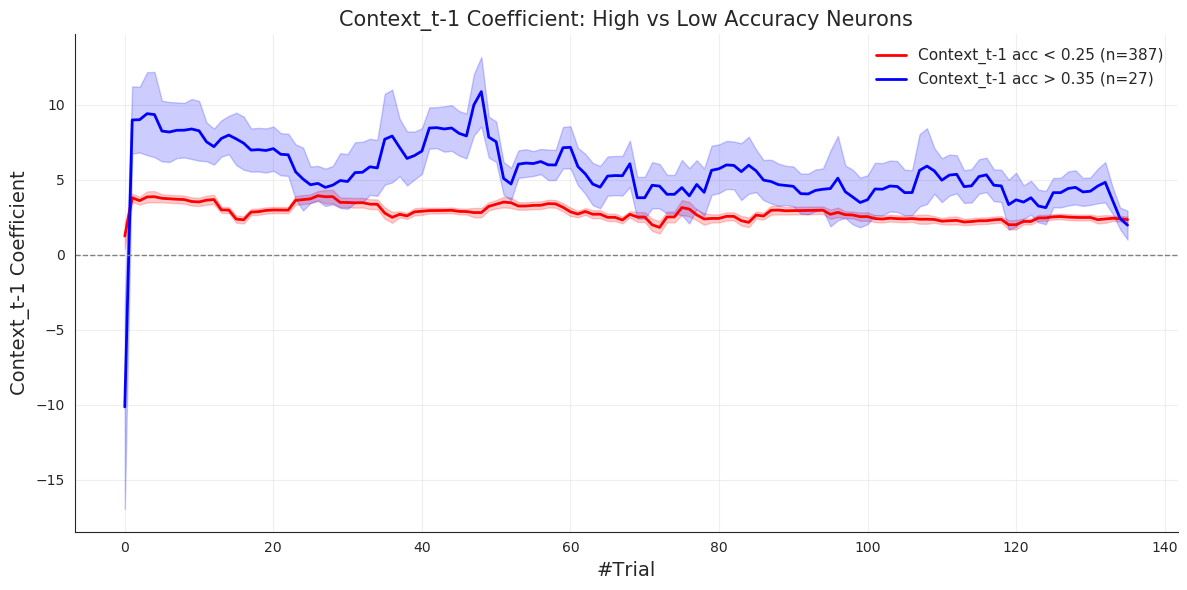

In [104]:
# Context_t-1 coefficient comparison
mask_low = df_rank.context.values < 0.25
mask_high = df_rank.context.values > 0.35

betas_low = betas_over_time[:, mask_low, :]
betas_high = betas_over_time[:, mask_high, :]

# Context_t-1 coefficient is at index 6
context_t1_idx = 6

plt.figure(figsize=(12, 6))

# Low accuracy group (acc < 0.25)
mean_low = betas_low[:, :, context_t1_idx].mean(axis=1)
sem_low = betas_low[:, :, context_t1_idx].std(axis=1) / np.sqrt(betas_low.shape[1])

plt.plot(mean_low, color='red', linewidth=2, label=f'Context_t-1 acc < 0.25 (n={betas_low.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_low - sem_low, 
                 mean_low + sem_low, 
                 alpha=0.2, color='red')

# High accuracy group (acc > 0.35)
mean_high = betas_high[:, :, context_t1_idx].mean(axis=1)
sem_high = betas_high[:, :, context_t1_idx].std(axis=1) / np.sqrt(betas_high.shape[1])

plt.plot(mean_high, color='blue', linewidth=2, label=f'Context_t-1 acc > 0.35 (n={betas_high.shape[1]})')
plt.fill_between(range(n_windows), 
                 mean_high - sem_high, 
                 mean_high + sem_high, 
                 alpha=0.2, color='blue')

plt.xlabel('#Trial', fontsize=14)
plt.ylabel('Context_t-1 Coefficient', fontsize=14)
plt.title('Context_t-1 Coefficient: High vs Low Accuracy Neurons', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()